# **Lab 1: Optimizing Generative AI Workloads with Embedded Arm Processors**


## **Introduction**

Welcome to the **Optimizing Generative AI Workloads with Embedded Arm Processors** lab! In this hands-on session, you will explore how Armv8-A advanced vector processing capabilities can significantly accelerate computationally intensive tasks commonly found in artificial intelligence (AI) applications. By the end of this lab, you will gain a deep understanding of how low-level optimizations can enhance performance and how to leverage these optimizations within high-level AI frameworks like PyTorch and lightweight inference libraries such as llama.cpp.

Specifically, you will learn how to optimize all layers of the stack, from low-level matrix multiplication in C using Arm's vector processing instructions to implementing weight-only quantization from scratch. You will demonstrate the deployment and optimization of the **OpenELM model** using llama.cpp, a state-of-the-art framework for efficient large language model inference on resource-constrained devices. This practical approach will showcase how to run modern generative AI workloads effectively on Arm hardware while minimizing latency and memory usage.

**Requirements**: To complete this lab, you will need an Armv8-A 64-bit system running a Linux-based operating system, such as a Raspberry Pi 4 or 5. The lab has been thoroughly tested on the Raspberry Pi 5 for compatibility and performance.

### **Why Arm Vector Instructions?**

Arm processors are ubiquitous in modern computing, powering everything from smartphones to edge devices and increasingly, servers and supercomputers. Their architecture is designed for energy efficiency and performance, making them ideal for deploying AI models in diverse environments. One of the key features that enable Arm processors to excel in AI workloads is their support for **vector instructions**, such as Neon and i8mm, which allow for parallel processing of multiple data points in a single instruction cycle. Armv8-A is a member of the Arm architecture family, representing the 8th generation of Arm's advanced architecture with a focus on 64-bit computing, high performance, and scalable designs. It builds upon the energy-efficient foundation of earlier Arm architectures while introducing advanced features such as support for AArch64 (the 64-bit instruction set), enhanced vector processing capabilities, and improved cryptographic extensions. Armv8-A is widely adopted in a range of mobile and embedded devices, including the **Raspberry Pi 4 and 5**.

### **Lab Objectives**

The objectives of this lab are as follows:

1. **Matrix Multiplication Optimization**:
   - Analyze three C-based matrix multiplication implementations (`naive`, `fp32_neon`, and `int8_neon`) to understand their performance differences.
   - Utilize Armv8's Neon vector processing capability to accelerate matrix multiplications, a fundamental operation of AI workloads.

2. **Benchmark PyTorch Operations**:
   - Measure the performance of PyTorch's matrix multiplication operations in different precisions.
   - Examine the generated assembly code to identify how PyTorch accelerates matrix multiplications.

3. **Run Inference on a Language Model**:
   - Load and run inference on the OpenELM model using llama.cpp.
   - Explore its computational graph to understand the underlying operations.

4. **Apply Integer Quantization**:
   - Learn how integer quantization can reduce model size and accelerate inference.
   - Implement and evaluate quantization on matrix multiplication operations.
   - Apply integer quantization to the OpenELM model and record its latency speedups and memory reductions.

5. **Deploy and Optimize llama.cpp on Arm**:
   - Understand the advantages of llama.cpp for running large language models on resource-constrained devices.
   - Set up, compile, and benchmark llama.cpp on Arm, including its utilization of quantized matrix multiplication.
   - Analyze the memory and latency trade-offs of llama.cpp compared to traditional frameworks like PyTorch.

### **What You Will Learn**

- **Low-Level Optimizations**: Understand how Arm's Neon SIMD instructions can accelerate matrix computations.
- **Performance Benchmarking**: Develop skills to benchmark operations effectively and analyze performance trade-offs.
- **Framework Integration**: Explore how low-level optimizations can complement high-level frameworks like PyTorch.
- **Quantization Techniques**: Learn to implement quantization for efficient AI workloads on resource-constrained devices.
- **Edge Deployment**: Practical deployment of llama.cpp for language model inference.

### **Prerequisites**

To follow this lab, you should have a basic understanding of:

- **C Programming**: Familiarity with C syntax and basic memory management.
- **Python Programming**: Experience writing and running Python scripts.
- **Matrix Operations**: A general understanding of matrix multiplication.
- **Knowledge of SIMD (Single Instruction, Multiple Data) and Transformer models**: This is covered in Chapter 2 and 4. 
- **Go through the first step of section 3**: This step, involves setting up a Hugging Face account, and downloading the OpenELM LLM. This can take around half an hour to complete.

---


## **1. Matrix Multiplication Optimization**

This lab begins with an exploration of matrix multiplication operators, the core computational components of AI workloads. Understanding and optimizing these operations can significantly enhance the inference performance of generative AI models. In this section, we will implement and compare three matrix multiplication approaches. While they are mathematically identical, their differing implementations result in vastly different performance outcomes. We will implement:

1. **Naive Kernel (`src/c/kernels/naive.c`)**  
   - A simple, baseline implementation of matrix multiplication to provide a reference point for performance.

2. **FP32 Neon Kernel (`src/c/kernels/fp32_neon.c`)**  
   - A matrix multiplication optimized for single-precision floating-point operations using Arm Neon SIMD instructions to leverage vectorized computation.

3. **INT8 Neon Kernel (`src/c/kernels/int8_neon.c`)**  
   - An integer matrix multiplication tailored for 8-bit operations, utilizing Neon SIMD to maximize throughput for lower-precision workloads.

By analyzing these implementations, you will gain insight into the performance trade-offs and benefits of hardware-specific optimizations that Arm can offer.

#### **Basic Mathematics of Matrix Multiplication**

Matrix multiplication is a fundamental operation in linear algebra with wide-ranging applications in computer science, engineering, and especially in machine learning and AI. Given two matrices **A** and **B**, the product **C = A × B** is defined only if the number of columns in **A** matches the number of rows in **B**.

Mathematically, if **A** is an *M × K* matrix and **B** is an *K × N* matrix, then their product **C** will be an *M × N* matrix. The element at position *(m, i)* in matrix **C** is computed as a dot product between row *m* of **A** and column *n* of B:

$$C_{m,n} = \sum_{k=1}^{K} A_{m,k} \times B_{k,n}$$

**Example:**

Consider matrices **A** (2×3) and **B** (3×2):

$$
\mathbf{A} = \begin{bmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23}
\end{bmatrix},
\quad
\mathbf{B} = \begin{bmatrix}
b_{11} & b_{12} \\
b_{21} & b_{22} \\
b_{31} & b_{32}
\end{bmatrix}
$$

Their product **C = A × B** (2×2) is:

$$
\mathbf{C} = \begin{bmatrix}
c_{11} & c_{12} \\
c_{21} & c_{22}
\end{bmatrix}
$$

where:

$$
\begin{align*}
c_{11} &= a_{11}b_{11} + a_{12}b_{21} + a_{13}b_{31} \\
c_{12} &= a_{11}b_{12} + a_{12}b_{22} + a_{13}b_{32} \\
c_{21} &= a_{21}b_{11} + a_{22}b_{21} + a_{23}b_{31} \\
c_{22} &= a_{21}b_{12} + a_{22}b_{22} + a_{23}b_{32}
\end{align*}
$$

#### **Computational Complexity**

The naive matrix multiplication algorithm has a time complexity of **O(n³)**, which becomes computationally expensive for large matrices. Optimizations, such as those leveraging vector instructions, aim to reduce the constant factors and improve cache utilization, thereby enhancing performance without altering the theoretical complexity.


<br><br><br>

### **Implementation of Naive Matrix Multiplication Kernel**

The naive implementation of matrix multiplication directly follows the mathematical definition. It uses three nested loops to compute the dot product of rows from matrix **A** and columns from matrix **B** for every element in the resulting matrix **C**. This is the most straightforward and intuitive approach but is computationally expensive due to its **O(n³)** time complexity.

#### **Code Explanation**

1. **Inputs**:
   - **A**, **B**: Flattened 2D matrices (stored as 1D arrays in row-major order) to be multiplied.
   - **C**: Flattened 2D matrix (1D array, also in row-major) to store the result.
   - **N**: Size of the square matrices (number of rows/columns).

2. **Procedure**:
   - The outer two loops iterate over the rows **i** and columns **j** of the resulting matrix **C**.
   - The innermost loop calculates the dot product for each element **C[i, j]** by summing the product of corresponding elements from row **i** of **A** and column **j** of **B**.

3. **Performance**:
   - This naive implementation is simple, performing one operation at a time but does not leverage advanced optimization techniques, such as blocking, vectorization, or parallelism.

#### **Naive Kernel Implementation**



In [1]:
!mkdir src/c/kernels

In [6]:
%%writefile src/c/kernels/naive.c

#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrix_multiply_naive(float* A, float* B, float* C, int K) {
    float accumulator;
    for (int m = 0; m < K; m++) {
        for (int n = 0; n < K; n++) {
            accumulator = 0.0f;
            for (int k = 0; k < K; k++) {
                accumulator += A[m * K + k] * B[k * K + n];
            }
            C[m * K + n] = accumulator;
        }
    }
}

Overwriting src/c/kernels/naive.c


### **Introduction to Neon SIMD Instructions**

Neon (Arm Advanced SIMD) is a set of SIMD instructions designed to accelerate data-parallel operations on Arm processors. By leveraging Neon, computations on matrices, such as matrix multiplication, can be vectorized to process multiple data points simultaneously, thereby reducing execution time and increasing throughput.

#### **FP32 Matrix Multiplication Using Neon Instructions**

1. **Vectorized Processing**:
   - In this implementation, the function processes four `float32` elements at a time, utilizing Neon's 128-bit registers (`float32x4_t`).
   - The accumulation is performed using fused multiply-add operations, which minimize intermediate memory accesses.

2. **Key Neon Instructions Used**:
   - **`vld1q_f32`**: Loads four 32-bit floating-point elements into a vector register.
   - **`vmlaq_f32`**: Performs a fused multiply-add operation on vectors.
     

3. **Reduction Step**:
   - The vector accumulator is reduced into a scalar using:
     - **`vadd_f32`**: Adds low and high parts of the vector.
     - **`vpadd_f32`**: Horizontally adds remaining elements for a final scalar result.
     - **`vget_lane_f32`**: Extracts a specific element (lane) from a vector, used here to retrieve the final scalar value from the result of `vpadd_f32`.
       
       
4. **Advantages Over Naive FP32 Implementation**:
   - **Efficient Memory Access**: The naive implementation loads a single value at a time from memory, which can result in significant memory latency. The Neon implementation processes four elements simultaneously, reducing memory fetch overhead.
   - **Reduced Loop Iterations**: By processing multiple elements in parallel, the Neon implementation reduces the number of loop iterations required in the inner loop, significantly improving performance for large matrices.
   - **Optimized Accumulation**: Neon's fused multiply-add (`vmlaq_f32`) performs multiplication and addition in a single instruction, minimizing intermediate storage, and computation overhead, unlike the naive implementation, which performs these operations sequentially.
   - **Hardware Acceleration**: Neon leverages specialized SIMD hardware in the Arm processor, making it much faster than the general-purpose computation used in the naive implementation.

5. **Description**:
   - The function performs matrix multiplication for `float32` matrices by iterating over the rows and columns of the input matrices, processing four elements at a time in the inner loop. This approach uses Neon to accelerate the computation by leveraging SIMD parallelism.



In [7]:
%%writefile src/c/kernels/fp32_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_fp32_neon(float* A, float* B, float* C, int K) {
    for (int m = 0; m < K; m++) {
        for (int n = 0; n < K; n++) {
            float32x4_t acc = vdupq_n_f32(0.0f); // Accumulator
            for (int k = 0; k < K; k += 4) { // Process 4 elements at a time
                float32x4_t a_vec = vld1q_f32(&A[m * K + k]); // Load row of A
                float32x4_t b_vec = vld1q_f32(&B[k * K + n]); // Load column of B
                acc = vmlaq_f32(acc, a_vec, b_vec); // Multiply-accumulate
            }
            // Reduce acc to a single value and store in C
            float32x2_t sum1 = vadd_f32(vget_low_f32(acc), vget_high_f32(acc));
            float sum = vget_lane_f32(vpadd_f32(sum1, sum1), 0);
            C[m * K + n] = sum;
        }
    }
}

Overwriting src/c/kernels/fp32_neon.c


### **Introduction to Quantized (INT8) Matrix Multiplication Using Neon SIMD**

Quantized matrix multiplication uses low-precision. In this case, 8-bit integer representations to reduce memory bandwidth, power consumption, and computational complexity. Arm processors with Neon (integer 8-bit matrix multiplication) instructions provide significant acceleration by increasing the level of vectorization and benefiting from the efficiency of integer arithmetic.

#### **INT8 Matrix Multiplication Using Neon Instructions**

1. **Increased Levels of Vectorization**:
   - The implementation processes eight `int8_t` elements at a time, leveraging the higher data packing density of 8-bit integers compared to `float32` (four elements at a time). This doubles the level of parallelism compared to the FP32 implementation.

2. **Key Neon Instructions Used**:
   - **`vld1_s8`**: Loads eight signed 8-bit integers into a vector register.
   - **`vmlal_s8`**: Multiplies two vectors of signed 8-bit integers and accumulates the results into 16-bit integers. Accumulation is done in 16-bit to avoid overflow.

3. **Reduction Step**:
   - **`vaddvq_s16`**: Horizontally sums the elements of a 16-bit integer vector to produce a scalar result.

4. **Advantages Over FP32 Implementation**:
   - **Higher Vectorization**: Processes eight elements at a time versus four in the FP32 version.
   - **Integer Arithmetic**: Integer operations are inherently faster than floating-point operations on most hardware due to simpler hardware requirements.
   - **Lower Memory Usage**: `int8_t` data consumes four times less memory than `float32`, leading to reduced cache pressure and better memory bandwidth utilization.
   - **Energy Efficiency**: Integer computations typically consume less power, making this approach ideal for energy-constrained environments.

5. **Description**:
   - The function performs matrix multiplication for quantized `int8` matrices by iterating over the rows and columns of the input matrices. In the inner loop, eight elements are processed simultaneously using Neon SIMD instructions. The 16-bit intermediate results are accumulated, and the final reduction produces a 32-bit scalar result for each element of the output matrix.




In [10]:
%%writefile src/c/kernels/int8_neon.c

#include <arm_neon.h>
#include <stdio.h>

void matmul_int8_neon(int8_t* A, int8_t* B, int32_t* C, int N) {
    for (int m = 0; m < N; m++) {
        for (int n = 0; n < N; n++) {
            int16x8_t acc = vdupq_n_s16(0); // Initialize 16-bit accumulator

            for (int k = 0; k < N; k += 8) { // Process 8 elements at a time
                // Load 8 int8 elements from row of A and column of B
                int8x8_t a_vec = vld1_s8(&A[m * N + k]);
                int8x8_t b_vec = vld1_s8(&B[k * N + n]);

                // Perform element-wise multiplication and accumulate
                acc = vmlal_s8(acc, a_vec, b_vec);
            }

            // Reduce the 16-bit accumulator into a 32-bit scalar
            int32_t sum = vaddvq_s16(acc); // Horizontally sum all elements in the vector
            C[m * N + n] = sum; // Store the result in C
        }
    }
}

Overwriting src/c/kernels/int8_neon.c


### **Compiling Each Kernel to Inspect Assembly Using GCC**

With the kernel implementations ready, we can compile them into assembly code to examine how the compiler leverages Neon hardware-level optimizations to enhance performance. This step provides insights into how SIMD instructions are utilized for accelerating computations, particularly for matrix operations.

#### **Steps to Compile Each Kernel**

To inspect the generated assembly code for each kernel, use the following GCC command:


In [12]:
!mkdir bin
!gcc -O0 -S -march=armv8-a+simd src/c/kernels/naive.c -o bin/naive.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/fp32_neon.c -o bin/fp32_neon.s
!gcc -O3 -S -march=armv8-a+simd src/c/kernels/int8_neon.c -o bin/int8_neon.s

---
### 1. **Naive Implementation**
   - uses scalar instructions exclusively, meaning each operation processes a single pair of data values at a time;
   - relies on the following types of Arm assembly instructions:
     - **`ldr` (Load Register):** loads a single value from memory into a register
     - **`str` (Store Register):** stores a single value from a register into memory
     - **`mul` (Multiply):** multiplies two values in registers
     - **`add` (Add):** adds two values in registers;
   - does not utilize SIMD capabilities, which can process multiple data values simultaneously in a single instruction; and
   - experiences significant overhead in memory operations due to the frequent use of `ldr` and `str` instructions for each operation, as no batching or parallelism is applied.

#### Observations:
   - computational units are underutilized because operations are performed serially, one at a time;
   - memory bandwidth becomes a bottleneck as frequent loads and stores slow down processing; and
   - best suited for small matrices or architectures without support for vectorized operations.

#### Example Assembly Output:
```assembly
ldr	w1, [sp, 44]   // Load word (32-bit) from stack offset 44 into w1
ldr	w0, [sp, 4]    // Load word (32-bit) from stack offset 4 into w0
mul	w1, w1, w0    // Multiply w1 = w1 * w0
ldr	w0, [sp, 40]   // Load another word from stack offset 40 into w0
add	w0, w1, w0    // Add w0 = w1 + w0
...


In [13]:
!sed -n '34,50p' bin/naive.s

	add	x0, x1, x0
	ldr	s1, [x0]
	ldr	w1, [sp, 32]
	ldr	w0, [sp, 4]
	mul	w1, w1, w0
	ldr	w0, [sp, 36]
	add	w0, w1, w0
	sxtw	x0, w0
	lsl	x0, x0, 2
	ldr	x1, [sp, 16]
	add	x0, x1, x0
	ldr	s0, [x0]
	fmul	s0, s1, s0
	ldr	s1, [sp, 44]
	fadd	s0, s1, s0
	str	s0, [sp, 44]
	ldr	w0, [sp, 32]


---
### 2. **Neon Vectorization**
   - leverages Neon SIMD instructions to perform parallel computations on multiple data values simultaneously:
     - **`movi` (Move Immediate):** initializes all elements of a Neon vector register to a specified immediate value (e.g., zero)
     - **`fmul` (Floating-Point Multiply):** multiplies corresponding elements in two Neon vector registers
     - **`fadd` (Floating-Point Add):** adds corresponding elements in two Neon vector registers
     - **`dup` (Duplicate):** copies a scalar value into all elements of a vector register or duplicates one element of a vector across a scalar register
     - **`faddp` (Floating-Point Add Pair):** adds adjacent pairs of elements within a vector register, effectively reducing the vector size.
   - processes 128-bit registers, enabling parallel computation of up to 4 single-precision floating-point numbers in a single instruction; and
   - utilizes optimized memory access patterns to minimize latency and bottlenecks.

#### Observations:
   - the extracted assembly demonstrates the use of Neon vector registers (e.g., `v0`, `v1`, `v2`) and instructions for efficient parallel floating-point computations; and
   - while the exact addresses or register assignments may vary slightly due to compiler differences, the core operations and use of Neon SIMD instructions remain consistent.

***NOTE***
If the code block below does not show the exact instructions described above, you can open the `bin/fp32_neon.s` file to view the full assembly. Regardless of compiler variations, you should see similar operations (e.g., `movi`, `fmul`, `fadd`, `dup`, `faddp`) utilizing Neon vector registers to perform SIMD optimizations.

#### Example Assembly Output:
```assembly
movi	v1.4s, 0               // Initialize all elements of v1 to zeros
fmul	v0.4s, v0.4s, v2.4s   // Multiply corresponding elements of v0 and v2, store result in v0
fadd	v1.4s, v1.4s, v0.4s   // Add corresponding elements of v1 and v0, store result in v1
dup	d0, v1.d[1]            // Duplicate the second 64-bit element of v1 into scalar register d0
fadd	v0.2s, v0.2s, v1.2s   // Add the lower two elements of v0 and v1, store result in v0.2s
faddp	v0.2s, v0.2s, v0.2s   // Pairwise add elements of v0.2s, reducing it to one scalar
...



In [14]:
!grep -E '\bv[0-9]+(\.[a-z0-9]+)?\b' bin/fp32_neon.s

	movi	v1.4s, 0
	fmul	v0.4s, v0.4s, v2.4s
	fadd	v1.4s, v1.4s, v0.4s
	dup	d0, v1.d[1]
	fadd	v0.2s, v0.2s, v1.2s
	faddp	v0.2s, v0.2s, v0.2s


### 3. **Neon Vectorization (Integer8-based)**

This implementation leverages Neon SIMD instructions for efficient integer matrix multiplication. While it does **not** utilize i8mm-specific instructions or other advanced Arm intrinsics, it achieves high performance with quantized data using the following Neon operations:

#### Key Neon Instructions Observed:
   - **`movi` (Move Immediate):** initializes all elements of a Neon vector register to a specified immediate value, such as zero;
   - **`smlal` (Signed Multiply-Add Long):** multiplies pairs of 8-bit integers from two vector registers, producing 16-bit results, and accumulates them into a 16-bit vector register;
   - **`addv` (Add Across Vector):** horizontally sums all elements of a Neon vector register into a single scalar value; and
   - **`smov` (Scalar Move):** moves the lowest element from a Neon vector register into a scalar general-purpose register.

#### Characteristics:
   - processes **8 `int8_t` elements at a time** due to Neon's 128-bit vector registers, allowing for significantly higher throughput compared to `float32` implementations;
   - accumulates intermediate results in 16-bit registers (`int16`) to avoid overflow during the computation; and
   - reduces the final 16-bit vector to a scalar using a horizontal sum (`addv`) followed by moving the scalar value to a general-purpose register (`smov`).

#### Observations:
   - **Performance Benefits**:
     - processes multiple `int8` elements per instruction, maximizing the benefits of vectorization; and
     - smaller data types (`int8` vs. `float32`) reduce memory bandwidth requirements and improve efficiency.
   - **Precision Limitations**:
     - integer arithmetic lacks the precision of floating-point operations, making it best suited for quantized workloads like neural network inference where reduced precision is acceptable.
   - **Applications**:
     - ideal for embedded systems, mobile devices, and other environments requiring low-power, memory-efficient AI inference.

***NOTE***  
If the code block below does not show the exact instructions described above, you can open the `bin/int8_neon.s` file to view the assembly. Regardless of compiler or system variations, the assembly will use similar operations (e.g., `movi`, `smlal`, `addv`, `smov`) to optimize the `int8` matrix multiplication using Neon SIMD instructions.

#### Example Assembly Output:
```assembly
movi	v0.4s, 0               // Initialize v0 to zeros
smlal	v0.8h, v2.8b, v1.8b   // Multiply 8-bit integers from v2 and v1, accumulate into 16-bit vector v0
addv	h0, v0.8h             // Horizontally sum all elements in v0.8h into scalar h0
smov	w0, v0.h[0]           // Move the lowest 16-bit value from v0 to scalar register w0


In [15]:
!grep -E '\bv[0-9]+(\.[a-z0-9]+)?\b' bin/int8_neon.s

	movi	v0.4s, 0
	smlal	v0.8h, v2.8b, v1.8b
	addv	h0, v0.8h
	smov	w0, v0.h[0]


### **Benchmarking**

Lets now compute the latency of results of these three operators across different matrix sizes top emprically measure their differences. We can set the matrix sizes used in the benchmark by writing them out to **src/c/sizes.c** as seen below. Feel free to adapt the sizes yourself to see how it can effect latency, Bear in mind however large matrix multiplications are compute intensive operations!

***Note***
This code is tested on Raspberry Pi 5 (Cortex-A76) with matmul size of 1024 can take upto 45s. 

In [16]:
%%writefile src/c/sizes.c

int sizes[] = {32, 64, 128, 256, 512};

Writing src/c/sizes.c


**Compile and Record Latency With the Naive Implementation**

In [17]:
# Compile the C code outputting the binary to bin/benchmark_naive
!mkdir results
!gcc -O0 src/c/benchmark_naive.c -o bin/benchmark_naive -march=armv8-a+simd -lm
!./bin/benchmark_naive

Naive Matrix Multiplication (Size 32): 0.000134 seconds
Naive Matrix Multiplication (Size 64): 0.001069 seconds
Naive Matrix Multiplication (Size 128): 0.008859 seconds
Naive Matrix Multiplication (Size 256): 0.081964 seconds
Naive Matrix Multiplication (Size 512): 1.056606 seconds


**Compile and Record Latency With the Floating-Point SIMD Implementation**

In [18]:
!gcc -O3 -ffast-math src/c/benchmark_fp32_neon.c -o bin/benchmark_fp32_neon -march=armv8-a+simd -lm
!./bin/benchmark_fp32_neon

FP32 Neon Matrix Multiplication (Size 32): 0.000010 seconds
FP32 Neon Matrix Multiplication (Size 64): 0.000073 seconds
FP32 Neon Matrix Multiplication (Size 128): 0.000583 seconds
FP32 Neon Matrix Multiplication (Size 256): 0.012042 seconds
FP32 Neon Matrix Multiplication (Size 512): 0.146004 seconds


**Compile and Record Latency With the Integer-8 SIMD Impelmentation**

In [19]:
!gcc -O3 -ffast-math src/c/benchmark_int8_neon.c -o bin/benchmark_int8_neon -march=armv8-a+simd -lm
!./bin/benchmark_int8_neon


Int8 Neon Matrix Multiplication (Size 32): 0.000005 seconds
Int8 Neon Matrix Multiplication (Size 64): 0.000035 seconds
Int8 Neon Matrix Multiplication (Size 128): 0.000247 seconds
Int8 Neon Matrix Multiplication (Size 256): 0.001872 seconds
Int8 Neon Matrix Multiplication (Size 512): 0.030810 seconds


## **Plot the Results** 
Great, now the operators have been run, lets plot how there latency scales with matrix size. 

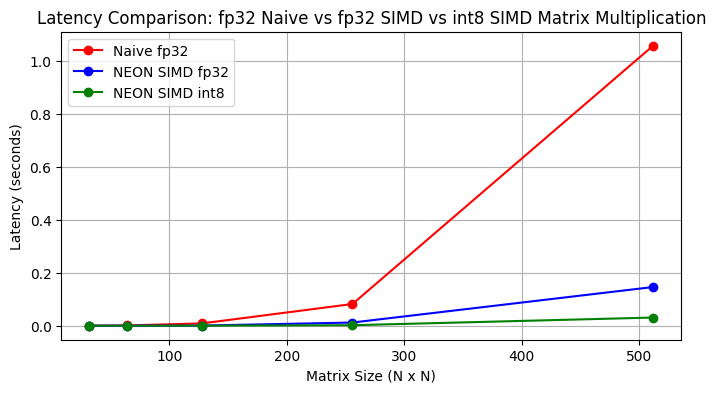

In [20]:
import matplotlib.pyplot as plt
import pandas as pd


# Load data from CSV files
naive_data = pd.read_csv('results/naive_latency_results.csv')
fp32_neon_data = pd.read_csv('results/fp32_neon_latency_results.csv')
int8_neon_data = pd.read_csv('results/int8_neon_latency_results.csv')

# Extract sizes and times
sizes = naive_data['Matrix Size']
naive_times = naive_data['Latency (seconds)']
fp32_neon_times = fp32_neon_data['Latency (seconds)']
int8_neon_times = int8_neon_data['Latency (seconds)']

plt.figure(figsize=(8, 4))

# Plotting the latency for each approach
plt.plot(sizes, naive_times, marker='o', linestyle='-', color='r', label='Naive fp32')
plt.plot(sizes, fp32_neon_times, marker='o', linestyle='-', color='b', label='Neon SIMD fp32')
plt.plot(sizes, int8_neon_times, marker='o', linestyle='-', color='g', label='Neon SIMD int8')

# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: fp32 Naive vs fp32 SIMD vs int8 SIMD Matrix Multiplication')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

As shown in the graph, the naive approach, which processes each matrix element individually, is the slowest. The SIMD floating-point implementation offers significant speedup, but the SIMD integer implementation is the fastest as it's the int8 lower bit-width allows a higher degree of parallelism. This highlights the advantage of using lower-precision operations in AI network forward passes for improved performance.

---
# **2. Benchmark PyTorch Operations**
#### **PyTorch**
Having explored how Arm's SIMD capabilities in C can accelerate AI workloads, we now transition to PyTorch which is a versatile, high-level framework that balances flexibility and ease of use. PyTorch streamlines AI model development by abstracting low-level operations, enabling developers to focus on model architecture and experimentation rather than intricate implementation details.

Unlike the manual coding required for SIMD operations in C, PyTorch offers built-in support for tensor computations and hardware acceleration. It automatically utilizes processor optimizations, including SIMD and Arm's Neon instructions, to enhance performance without requiring developers to write low-level code.

In the next section, we will examine how PyTorch utilizes the Armv8-A's vectorization capability and benchmark Python-based matrix multiplication using both `int8` and `fp32` precision. Building on this foundation, we will implement and optimize the inference of a state-of-the-art small language model, **OpenELM**, showcasing PyTorch's powerful capabilities for handling advanced AI workloads on Armv8.

Let's start by checking the build configuration of our installed PyTorch package. 

In [21]:
import torch
print(torch.__config__.show())

PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: DEFAULT
  - Build settings: BLAS_INFO=open, BUILD_TYPE=Release, COMMIT_SHA=2236df1770800ffea5697b11b0bb0d910b2e59e1, CXX_COMPILER=/opt/rh/gcc-toolset-11/root/usr/bin/c++, CXX_FLAGS=-ffunction-sections -fdata-sections -D_GLIBCXX_USE_CXX11_ABI=1 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOCUPTI -DLIBKINETO_NOROCTRACER -DLIBKINETO_NOXPUPTI=ON -DUSE_PYTORCH_QNNPACK -DAT_BUILD_ARM_VEC256_WITH_SLEEF -DUSE_XNNPACK -DSYMBOLICATE_MOBILE_DEBUG_HANDLE -O2 -fPIC -Wall -Wextra -Werror=return-type -Werror=non-virtual-dtor -Werror=range-loop-construct -Werror=bool-operation -Wnarrowing -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-unused-parameter -Wn

In this output, you can see the build configuration for this version of PyTorch. Some key flags indicate how PyTorch is optimized for performance on the your device:

- **`USE_OPENMP=ON`**: This library is used to parallelize matrix multiplications across threads, providing speedups on the Raspberry Pi's quad-core processor.
- **`BLAS_INFO=ON`** BLAS (Basic Linear Algebra Subprograms) are used to perform efficient linear algebra on Arm utilizing vector processing. 
- **`USE_NNPACK=ON`**: A low-level library of operators that utilizes vectorized instructions on Arm processors to accelerate operations.
- **`USE_MKLDNN=ON`**: While primarily designed for x86 processors, this library also includes vectorized implementations of operators optimized for the AArch64 architecture, making it compatible with devices like the Raspberry Pi 4 and 5.

These build configurations show that PyTorch is equipped to take advantage of Arm's vectorization and multi-threading capabilities. 

Next, let's validate that PyTorch is successfully utilizing these low-level libraries to vectorize its tensor operations.

---

### **Analyzing PyTorch's Utilization of Arm Vector Processing**

To confirm PyTorch's use of Arm's vector processing capabilities, we will investigate its behavior under the hood by writing two simple scripts for matrix multiplication. These scripts replicate what we implemented in C earlier but leverage PyTorch's abstractions. 

The scripts will perform matrix multiplication using both 32-bit floating-point (`fp32`) and 8-bit integer (`int8`) precisions. PyTorch simplifies these operations by providing built-in functionality that abstracts away low-level details, enabling developers to focus on high-level design while still benefiting from hardware optimizations.


In [22]:
!mkdir src/python

In [23]:
%%writefile src/python/fp_matmul.py

import torch
a = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
b = torch.randn(1024, 1024, dtype=torch.float32, requires_grad=False)
c = torch.mm(a, b)

Writing src/python/fp_matmul.py


In [24]:
%%writefile src/python/int8_matmul.py
import torch

# Generate random int8 tensors
a = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
b = torch.randint(-128, 128, size=(1024, 1024), dtype=torch.int8)
c = torch.mm(a, b)

Writing src/python/int8_matmul.py


### **Using `perf` to Inspect Assembly**

The following code cells use the `perf` tool to extract the assembly instructions executed by the Python scripts above. By capturing this assembly, we can analyze whether the low-level libraries that `torch.mm` relies on for matrix multiplication are effectively utilizing Arm's vector processing capabilities, such as Neon instructions.

We will write the extracted assembly code to a text file for further analysis. This process allows us to verify if PyTorch's operations are optimized to leverage hardware acceleration on Arm-based systems.

**Note**: In the following cells may take a few seconds to run. 


In [25]:
!perf record -e instructions:u -c 100000000 -g $(which python) src/python/fp_matmul.py

[ perf record: Woken up 1 times to write data ]
[ perf record: Captured and wrote 0.044 MB perf.data (64 samples) ]


In [26]:
!perf annotate > results/fp_matmul_instructions.txt

**Extract Assembly for the Floating-Point matmul**

In [27]:
!perf record -e instructions:u -c 100000000 -g $(which python) src/python/int8_matmul.py 

[ perf record: Woken up 1 times to write data ]
[ perf record: Captured and wrote 0.045 MB perf.data (66 samples) ]


In [28]:
!perf annotate > results/int8_matmul_instructions.txt

**Extract Assembly for the int8 matmul**

- Now lets have a look inside the instructions used by PyTorch for the floating-point matrix multiply script and print them below. We will search for instructions such as `fmul` to detect their presence and ensure they are using the vector registers for acceleration with Neon SIMD.

In [29]:
!grep -m 20 -E '\bv[0-9]+(\.[a-z0-9]+)?\b' results/fp_matmul_instructions.txt

    0.00 :   10b0ac: add     v0.2s, v0.2s, v1.2s
    0.00 :   10b628: add     v0.2s, v0.2s, v1.2s
    0.00 :   10b7a4: add     v0.2s, v0.2s, v1.2s
    0.00 :   86bc:   mov     v0.d[1], x24
    0.00 :   2bb2b8: fmul    v16.4s, v0.4s, v8.s[0]
    0.00 :   2bb2bc: fmul    v20.4s, v0.4s, v9.s[0]
    0.00 :   2bb2c4: fmul    v24.4s, v0.4s, v10.s[0]
    0.00 :   2bb2c8: fmul    v28.4s, v0.4s, v11.s[0]
    0.00 :   2bb2d0: fmul    v17.4s, v1.4s, v8.s[0]
    0.00 :   2bb2d4: fmul    v21.4s, v1.4s, v9.s[0]
    0.00 :   2bb2dc: fmul    v25.4s, v1.4s, v10.s[0]
    0.00 :   2bb2e0: fmul    v29.4s, v1.4s, v11.s[0]
    0.00 :   2bb2e8: fmul    v18.4s, v2.4s, v8.s[0]
    0.00 :   2bb2ec: fmul    v22.4s, v2.4s, v9.s[0]
    0.00 :   2bb2f4: fmul    v19.4s, v3.4s, v8.s[0]
    0.00 :   2bb2f8: fmul    v23.4s, v3.4s, v9.s[0]
    0.00 :   2bb300: fmul    v26.4s, v2.4s, v10.s[0]
    0.00 :   2bb304: fmul    v30.4s, v2.4s, v11.s[0]
    0.00 :   2bb30c: fmul    v27.4s, v3.4s, v10.s[0]
    0.00 :   2bb310: fmu

You should see printed out above some assembly instructions that the Arm processor will run. the structure of each line written out by `perf annotate` has the following format

***timestamp :    instruction_address: operation:   destination_registor, source_register1, source_register2***

The printout should show operations making use of the vector registers. Examples of operations you might see include.   

#### **Operation Definitions**
- **`fmul`**: Performs a floating-point multiplication operation between two operands.
- **`fmla`**: Performs a floating-point fused multiply-add operation, where the result of the multiplication is added to an accumulator in a single instruction.

- **Vector Registers**: Source or destination registers starting with a `v` (e.g., `v16.4s`, `v0.4s`, `v8.s[0]`) indicate that Neon SIMD instructions are being used. These registers contain multiple data lanes, enabling the instruction to process multiple elements simultaneously, thereby increasing throughput.
  - Example: `fmla v16.4s, v0.4s, v8.s[0]` performs the fused multiply-add operation on four single-precision floating-point elements in parallel (one for each lane of the vector register `v16`)..


***Note*** Should no vector registers show up in your instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 


In [30]:
!grep -m 20 -E '\bv[0-9]+(\.[a-z0-9]+)?\b' results/int8_matmul_instructions.txt

    0.00 :   451bd68:        dup     v2.16b, w0
    0.00 :   451bd78:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   451bdb0:        dup     v1.8b, w0
    0.00 :   451bdc4:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   451c0e4:        movi    v0.4s, #0x0
    0.00 :   451c104:        mla     v0.16b, v2.16b, v1.16b
    0.00 :   451c110:        addv    b0, v0.16b
    0.00 :   451c11c:        umov    w12, v0.b[0]
    0.00 :   451c15c:        mul     v0.8b, v0.8b, v1.8b
    0.00 :   451c160:        addv    b0, v0.8b
    0.00 :   451c164:        umov    w12, v0.b[0]
    0.00 :   451c3d0:        dup     v2.16b, w0
    0.00 :   451c3e0:        mla     v0.16b, v1.16b, v2.16b
    0.00 :   451c414:        dup     v1.8b, w0
    0.00 :   451c428:        mla     v0.8b, v2.8b, v1.8b
    0.00 :   451c740:        movi    v3.4s, #0x0
    0.00 :   451c750:        mov     v22.16b, v3.16b
    0.00 :   451c754:        mov     v21.16b, v3.16b
    0.00 :   451c758:        mov     v9.16b, v3.16b
    0.00

Examples of instructions you might see in the output above are: 
- **`dup`**: Duplicates the value of a scalar register (e.g., `w0`) into all lanes of a SIMD vector register (e.g., `v2.16b`). This allows the same value to be broadcast across multiple lanes for parallel processing.
- **`mla`**: Performs a fused multiply-accumulate operation. It multiplies corresponding elements from two SIMD vector registers and adds the results to the accumulator register. This operation is performed on all lanes in parallel.
- **`addv`**: Adds all elements in a SIMD vector register and stores the resulting sum in a scalar register. This is typically used for reduction operations to aggregate data from multiple lanes during accumulation of dot product results.
- **`umov`**: Extracts a specific lane from a SIMD vector register and moves it to a scalar register. This is useful for accessing individual elements after SIMD processing (e.g. accessing the sum of a dot product).

These presence of these instructions shown above indicate that torch is utilizing Arm's SIMD capabilities. 

***Note*** Should no vector registers show up in the instruction list above, please look inside the file results/fp_matmul_instructions.txt to identify any vector register utilization. 

## **Benchmarking PyTorch Linear Layer**
Great. Now you have verified that PyTorch is utilizing the vector processing capability of Arm by defualt, we can benchmark it's operations. Specifically, let's benchmark the floating-point and integer precision operations. Just like our above kernel examples writte in C. We should see a measurable latency reduction when processing in int8 precision vs fp32.

**Write a Latency Measuring Function**

In [31]:
import time 
import numpy as np
torch.set_num_threads(1)

def benchmark(inputs, func, num_runs=10): 
    times = []
    for _ in range(3): # warm up 
        func(inputs)

    for _ in range(num_runs):  # timing runs
        st = time.time()
        func(inputs)
        times.append(time.time() - st)

    return np.mean(times)

**Once Again Specify the Size of Matrices to Evaluate**

Feel free to adjust the matrix sizes to identify how much computation large matrix multiply's require!

In [32]:
import torch 
sizes = [32, 64, 128, 256, 512, 1024]

**Record Latencies for a Full Precision Linear Layer**  
The linear layer is a fundamental building block of generative AI models like transformers, performing dense matrix multiplications at its core. Given input $ X \in \mathbb{R}^{m \times n} $ and weights $ W \in \mathbb{R}^{n \times p} $, the output $ Y \in \mathbb{R}^{m \times p} $ is computed as $ Y = XW + b $, where $ b $ is an optional bias term. Measuring the latency of these FP32 matrix multiplications provides a baseline for assessing performance and comparing with optimized or quantized implementations.

In [33]:
import torch 
import torch.nn as nn

float_times = []
for size in sizes:
    # floating-point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    linear = nn.Linear(size, size, bias=False)
    float_times.append(benchmark(x, linear))

**Record Latencies for an INT8 Quantized Linear Layer**  
In a quantized linear layer, the computation $ Y = XW + b $ is performed using INT8 precision for the operands $ X $ (input) and $ W $ (weights), while optionally adding a bias $ b $ in a higher precision (e.g., INT32 or FP32) to preserve accuracy. Quantization maps the original floating-point values to 8-bit integers using a scale $ S $ and zero-point $ Z $, such that $ x_\text{quant} = \text{round}(x / S) + Z $. This allows efficient matrix multiplications in reduced precision while maintaining a close approximation of the original computation.



In [34]:
import torch 
import torch.nn.quantized as nnq
torch.backends.quantized.engine = 'qnnpack'
int8_times = []
for size in sizes:
    # floating-point measurements 
    x = torch.randn(size, size, dtype=torch.float32, requires_grad=False)
    x_quant = torch.quantize_per_tensor(x, scale=x.abs().max()/127, zero_point=0, dtype=torch.qint8)
    qlinear = nnq.Linear(size, size, dtype=torch.qint8)
    qlinear.set_weight_bias(x_quant, None)
    int8_times.append(benchmark(x_quant, qlinear))

## Plot the Scaling Results

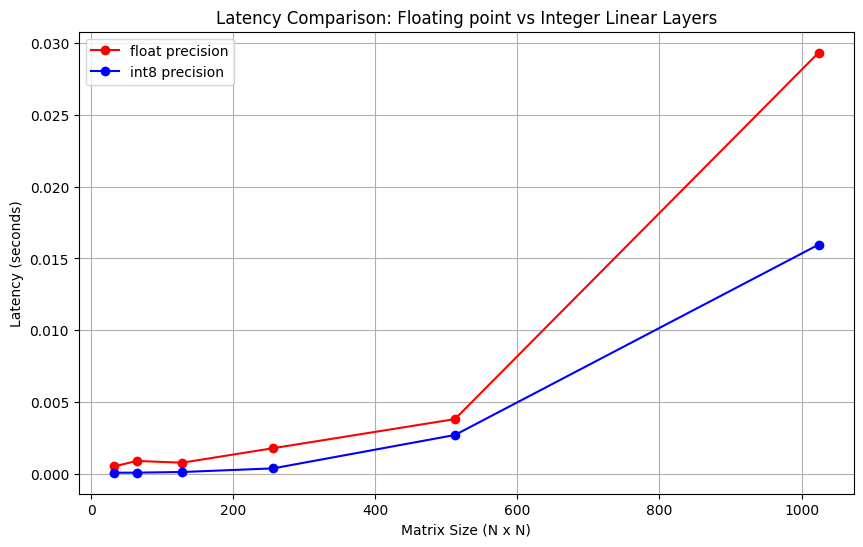

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))

# Plotting the latency for each approach
plt.plot(sizes, float_times, marker='o', linestyle='-', color='r', label='float precision')
plt.plot(sizes, int8_times, marker='o', linestyle='-', color='b', label='int8 precision')
# Adding labels and title
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Latency (seconds)')
plt.title('Latency Comparison: Floating-point vs Integer Linear Layers')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


You should be able to see that for small matrices, there is little difference in latency for processing floating-point and integer linear layers. As the matrix size increases, the integer linear layer latency should increase slower than floating point. Therefore if we can quantize linear layers, used by generative AI models from floating-point to integer values without losing too much accuracy, we can see a significant latency improvement (not to mention reduced memory consumption).

---
# **3. Run Inference on a Language Model**

### How to Download and Use **OpenELM** from Hugging Face

OpenELM is a recently released, small open-source language model by Apple, designed for efficient local deployment [(OpenELM Paper)](https://arxiv.org/abs/2404.14619). It comes in compact sizes: 270M, 450M, 1.1B, and 3B, making it ideal for embedded applications. In this lab, we will use OpenELM-270M and focus on optimizing its inference speed on Arm devices.

1. **Log In or Sign Up**  
   If you don’t already have a Hugging Face account, create one. Otherwise, log in to your existing account.

2. **Visit the Model Page**  
   Navigate to the [apple/OpenELM](https://huggingface.co/apple/OpenELM) page on Hugging Face.

3. **Request Access**  
   On the model's page, click the **"Access repository"** button. You’ll be prompted to review and agree to the terms of use.

4. **Visit the Lamma Model Page**
   Navigate to the [meta-llama/Llama-2-7b-hf](https://huggingface.co/meta-llama/Llama-2-7b-hf) page on Hugging Face. You need to do this, as the OpenELM model uses the Lamma Tokenizer. 

5. **Request Access**  
   On the model's page, click the **"Access repository"** button. You’ll be prompted to review and agree to the terms of use.

6. **Wait for Approval**  
   After agreeing to the terms, access will be granted. This may take a few hours where you should receive a notificatino via email.

7. **Login via the Command Line**

To download the model, you may need to authenticate your Hugging Face account on your local machine. Run the following command in your terminal and follow the prompts to log in (this will involve creating an access token for your local machine):

   ```bash
   huggingface-cli login
   ```

After following the prompted authentication steps, you can download and use the model with the following script.

**NOTE** This script may take up to half an hour to run the first time it is executed. This is because the Hugging Face package needs to download the model weights. After the initial execution, reloading the model should be faster (45s on Rasberry Pi 5) since Hugging Face caches the weights locally.

In [37]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()

A new version of the following files was downloaded from https://huggingface.co/apple/OpenELM-270M-Instruct:
- modeling_openelm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps=1e-06)
        (attn_norm):

**Let’s Run a Prompt Through the Instruction-Tuned Model and See What It Generates**

OpenELM is a small, instruction-finetuned language model trained to understand and generate outputs tailored to specific instructions or tasks. Unlike its base version, which functions as an autocomplete engine, the instruction-tuned model is optimized to follow detailed prompts and generate contextually relevant completions or answers.

In this lab, we will explore its capabilities by providing it with a prompt and observing how it completes the instruction. For demonstration purposes, we’ll set a maximum sequence length of 30 tokens to manage computational costs and observe its output for the prompt: 

***"Arm is a company that designs"***.

In [38]:
prompt = "Arm is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=30)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Arm is a company that designs and manufactures microcontrollers, which are tiny electronic devices that can perform specific functions. The company has been


**Let's Measure the Static Memory Consumption of the Model in PyTorch Format.** 

In [39]:
import os 

def get_directory_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    return total_size

model.save_pretrained("checkpoints/OpenELM-hf")
pytorch_model_size = get_directory_size("checkpoints/OpenELM-hf") / (1024 ** 2)
print(f"PyTorch Model Size: {pytorch_model_size:.1f} MB")

PyTorch Model Size: 1035.8 MB


Wow, that's a significant amount of memory consumption, 1GB for the 270M model! Many small embedded devices may struggle to handle this. Therefore, it's crucial to explore strategies for reducing the model's memory footprint, alongside improving inference speed. Doing so will expand the range of devices capable of running the model and, since memory access is energy-intensive, it will also reduce energy consumption and extend battery life. Next however, lets look at the latency bottlenecks and dynamic memory usage during inference with `torch.profiler`.

In [40]:
import torch
from torch.profiler import profile, ProfilerActivity, record_function
prompt = "Arm is a company that designs and develops microprocessors and other microchips. It is also known for its Arm Cortex processor and the Arm Mali GPU. Arm has been a leader in the mobile computing industry since the early 2000s, and is now a major player in the AI and "
inputs = tokenizer(prompt, return_tensors="pt")
# Profile the model
with profile(
    activities=[ProfilerActivity.CPU],
    record_shapes=True,
    with_stack=True,
    profile_memory=True,
) as prof:
    with record_function("model_inference"):
        with torch.no_grad():
            outputs = model(**inputs)

# Print a summary
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


[W303 11:20:47.257212452 CPUAllocator.cpp:245] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event


-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-----------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                      model_inference         3.08%      33.236ms       100.00%        1.080s        1.080s      16.54 Mb    -200.00 Mb             1  
                                         aten::linear         0.04%     464.702us        84.95%     917.760ms      14.119ms      52.28 Mb           0 b            65  
                                         aten::matmul         0.21%       2.287ms        84.79%     916.018ms      14.093ms      52.28 Mb           0 b         

Your output should look something like this for OpenELM-270M

| **Name**                                      | Self CPU % | Self CPU   | CPU total % | CPU total   | CPU time avg  | CPU Mem      | Self CPU Mem | # of Calls |
|-----------------------------------------------|------------|------------|-------------|-------------|---------------|--------------|--------------|------------|
| model_inference                               | 6.98%      | 141.663ms  | 100.00%     | 2.029s      | 2.029s        | 16.54 Mb     | -204.71 Mb   | 1          |
| aten::matmul                                  | 0.74%      | 14.967ms   | 72.95%      | 1.480s      | 15.262ms      | 61.69 Mb     | 0 b          | 97         |
| aten::linear                                  | 0.16%      | 3.303ms    | 66.95%      | 1.359s      | 20.901ms      | 52.28 Mb     | 0 b          | 65         |
| aten::mm                                      | 66.16%     | 1.342s     | 66.16%      | 1.342s      | 20.654ms      | 52.28 Mb     | 52.28 Mb     | 65         |
| aten::scaled_dot_product_attention            | 0.24%      | 4.773ms    | 8.46%       | 171.761ms   | 10.735ms      | 4.43 Mb      | -4.98 Mb     | 16         |
| aten::_scaled_dot_product_attention_math      | 0.08%      | 1.567ms    | 8.23%       | 166.988ms   | 10.437ms      | 9.41 Mb      | -13.84 Mb    | 16         |
| aten::bmm                                     | 4.62%      | 93.766ms   | 5.68%       | 115.326ms   | 3.604ms       | 9.41 Mb      | 4.54 Mb      | 32         |
| aten::embedding                               | 1.21%      | 24.580ms   | 3.59%       | 72.850ms    | 72.850ms      | 360.00 Kb    | 0 b          | 1          |
| aten::silu                                    | 3.18%      | 64.437ms   | 3.18%       | 64.437ms    | 4.027ms       | 12.80 Mb     | 12.80 Mb     | 16         |
| aten::index_select                            | 1.70%      | 34.598ms   | 2.24%       | 45.386ms    | 45.386ms      | 360.00 Kb    | 360.00 Kb    | 1          |

**Self CPU time total:** 2.029s

---

### Key Takeaways from Profiling

- **Matrix Multiplications (aten::mm)**: The dominant computational operation, accounting for 66% of the total CPU computation time. Dense layers (e.g., `aten::linear`) rely heavily on these operations.
- **Scaled Dot Product Attention**: The attention mechanism contributes to 8.46% of the total computation time and uses relatively moderate memory at 4.43 MB. This may increase for increased context lengths, due to the quadratic complexity of the attention mechanism.
- **Memory Usage**: Matrix multiplications (`aten::mm`) are the most memory-intensive operation, allocating 52.28 MB. 

---


### **Optimization Focus**

**Matrix multiplications in Dense Layers Are Among the Most Critical Operations to Optimize.**  
These operations dominate both computation and memory usage, making them a primary target for performance improvements. Optimization techniques such as vectorization and quantization, discussed in earlier sections, can significantly enhance efficiency and reduce memory usage.

In this section, we will begin by lowering the precision of the feedforward linear layers (heavily reliant on matrix multiplications) to the `int8` datatype. This process, known as **quantization**, can greatly improve performance. Specifically, we will explore a technique called **Integer Per-Tensor Symmetric Weight-Only Quantization**. A bit of a mouthful, but let’s break it down how it works. 

#### **Integer Per-Tensor Symmetric Weight-Only Quantization**

Integer symmetric weight-only quantization reduces a neural network's weight precision from floating-point to integer values, while keeping activations in floating-point format during inference, hence why it is called weight-only. Although in this format, the underlying matrix multiplication still occurs in floating-point, for example via `torch.mm(W.dequantize(), x)`, weight-only quantization can decrease the model's static memory consumption by up to 4x. Additionally in cases where inference speed is limited by memory bandwidth, reducing the weight precision can also lower memory read latencies, further speeding up inference. Now lets go through some of the maths:

Given that the equation of the linear layer s is outlined below, where $X^{fp}$ is the input activation, $W^{fp}$ the floating-point weight matrix and $B^{fp}$ where the superscript $fp$ denotes that the input activation, weight, and bias are in floating point. 

$y = X^{fp}W^{fp} + B^{fp}$

To apply Symmetric Per-Tensor weight-only quantization, the floating-point weights $W^{fp}$ are quantized to integer values $ W^{q} $ using a single scale factor $ S_w $ which is a floating-point value. This scalar maps the floating-point range of the weight, to integer range e.g. (-128, 127) for `int8`. It can be computed based on the maximum absolute weight value: where |W| is the absolute weight matrix and $b$ is the number of bits in the integer value, for `int8` it is 8. (Note: don't confuse the bias $B^{fp}$ with the number of bits $b$)

$
S_w = \frac{\max(|W^{fp}|)}{2^{b-1} - 1}
$


Given that this scale $S_w$ value maps the floating-point weight range to the integer weight range. The quantization and dequantization processes are given by:

- **Quantization**:
  $
  W^{q} = Q_w(W^{fp}) = \text{round}\left( \frac{W^{fp}}{S_w} \right)
  $

- **Dequantization**:
  $
  W^{fp} \approx \hat{W}^{fp} = DQ(W^{q}, S_w) = W_Q \cdot S_w
  $


During inference, both the weights and activations must share the same precision for the hardware's multipliers to perform matrix multiplication. When weights are quantized to `int8` $ W^q $ but activations remain in floating-point $X^{fp}$, a mismatch occurs. To resolve this, the quantized weights must be dequantized back into floating-point values before computation.

$
y = X^{fp} \hat{W}^{fp}  + B^{fp} \approx X^{fp} (W^q \cdot S_w) + B^{fp}
$


Lets now collect an intermediate weight matrix and activation tensor from one of the feed forward layers in the OpenELM model so we can practice this quantization techniqe. We can do this collection using a functionality of PyTorch called forward hooks. You can set the variable `layer_idx` in the code below to select a given transformer block from the OpenELM model from which you want to extract the weight matrix and activation tensor. 

In [42]:
import torch
# Initialize dictionary to store activations
activations = {}

# Define a hook function to capture input
def get_activation_input(name):
    def hook(model, input, output):
        # 'input' is a tuple; we take the first element for the input tensor
        activations[name] = input[0]
    return hook

# Select the transformer block and register the hook
layer_idx = 12  # Select the transformer block of your choosing
layer = model.transformer.layers[layer_idx].ffn.proj_2
hook_handle = layer.register_forward_hook(get_activation_input('proj_2'))

# Run the model forward pass
with torch.no_grad():
    model(**inputs)

# Extract the weight matrix and the input activation tensor from the hook
W_fp = layer.weight.data.clone()
X_fp = activations['proj_2']
hook_handle.remove()

print(f"The collected weight matrix has shape {W_fp.shape[0]}x{W_fp.shape[1]} (output_channels x input_channels)")
print(f"The collected input activation tensor has shape {X_fp.shape[0]}x{X_fp.shape[1]}x{X_fp.shape[2]} (batch_size x sequence_length x input_channels)")


The collected weight matrix has shape 1280x4352 (output_channels x input_channels)
The collected input activation tensor has shape 1x72x4352 (batch_size x sequence_length x input_channels)


Great!, now we have collected a weight matrix and activation tensor from the inside of the OpenELM feedforward layers. We can now use these to test the accuracy of the quantization technique. Lets start by implementing the per-tensor quantization technque described above. We will omit the bias, as in the case of the OpenELM model, it's feedforward layers do not use biases. 

In [45]:
# Re-compute the output of the linear layer before quantization to compare against our quantized version. 
y = torch.matmul(X_fp, W_fp.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization (int8 quantization)
S_w = W_fp.abs().max() / (2**(b-1) - 1)  # Scale Factor Quantization
W_q = torch.round(W_fp / S_w).clamp(-2**(b-1), 2**(b-1) - 1)  # Quantizing the weights (clamp is used to prevent overflow)

# Weight-only quantized linear layer
y_hat = torch.matmul(X_fp, (W_q * S_w).t()) # Notice the Dequantzation step here (Q * S)

Let's check the quantization error to see if we have correctly approximated the full precision linear layer. This can be defined as the absolute difference between the full precision linear layer and our quantized version. Using our notation, where $y$ is the full precision output, $\hat{y}$ is the quantized output, $Q_w$ is the quantized tensor, and $S_w$ is the scale factor, the quantization error can be expressed as:

$$
\text{Quantization Error} = \left| y - \hat{y} \right| = \left| y - X^{fp} \cdot (W^q \cdot S_w) \right|
$$

Additionally, the relative quantization error as a percentage can be calculated to understand the error in relation to the magnitude of the full precision output:

$$
\text{Relative Quantization Error (\%)} = \left( \frac{\left| y - \hat{y} \right|}{\left| y \right|} \right) \times 100
$$

This relative error provides a normalized measure of the quantization error, making it easier to compare across different scales of output values.

In [46]:
# Calculate quantization error. This is the difference between the full precision linear layer and our quantized version. 
residuals = (y - y_hat).abs()
residuals_rel = (residuals / y.abs()) * 100
print(f"Max relative quantization error: {residuals_rel.max():.2f} (%)")
print(f"Min relative quantization error: {residuals_rel.min():.2f} (%)")
print(f"Mean relative quantization error: {residuals_rel.mean():.2f} (%)")

Max relative quantization error: 340510.56 (%)
Min relative quantization error: 0.00 (%)
Mean relative quantization error: 37.54 (%)


You should see that the mean, min, and max relative quantization error. The max relative quantization error may be huge. This is caused by outliers in the activation and/or weight matrix that can skew the quantization error. There are a number of techniques to mitigate this issue. We will not cover them here but you can learn more about them in the [LLM.int8() paper](https://arxiv.org/abs/2208.07339). 

This is a good start but the mean quantization error is still relativly high which may cause accuracy degredation. We can do better. To do so lets try and understand what the distribution of the data in the weight matrix looks like, this will give an indication as to why the quantization error might be so high. Below we will plot a boxplot of the 4 largest and 4 smallest output channels in your chosen layer (set by the layer_idx variable). This essentially plots the weight distribution of the largest and smallest rows in the weight matrix $W$.

(4352, 10)


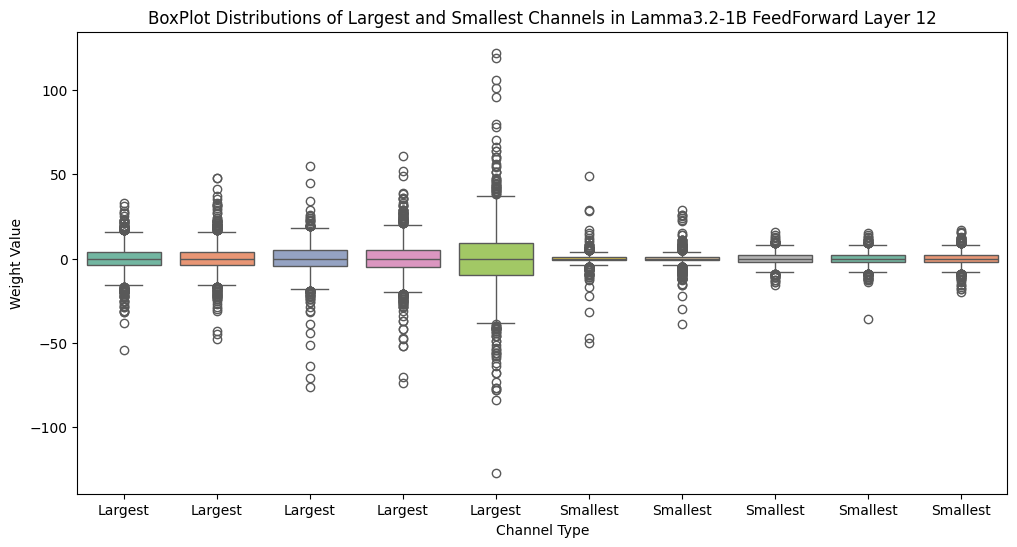

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the L2 norm of each channel along axis 1
channel_magnitudes = np.linalg.norm(W_q.clone().numpy(), axis=1)

num_channels_to_select = 5
largest_channels_indices = np.argsort(channel_magnitudes)[-num_channels_to_select:]
smallest_channels_indices = np.argsort(channel_magnitudes)[:num_channels_to_select]

# Select the largest and smallest channels along axis 1
largest_channels = W_q.numpy()[largest_channels_indices, :]
smallest_channels = W_q.numpy()[smallest_channels_indices, :]

# Combine the data for boxplot
combined_data = np.concatenate((largest_channels, smallest_channels), axis=0)
labels = ['Largest'] * num_channels_to_select + ['Smallest'] * num_channels_to_select

combined_data = combined_data.T
print(combined_data.shape)
# Plot boxplot for the selected channels
def plot_combined_boxplot(combined_data, labels):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_data, palette="Set2")
    plt.xticks(ticks=np.arange(len(labels)), labels=labels * (combined_data.shape[1] // len(labels)))
    plt.title(f'BoxPlot Distributions of Largest and Smallest Channels in Lamma3.2-1B FeedForward Layer {layer_idx}')
    plt.xlabel('Channel Type')
    plt.ylabel('Weight Value')
    plt.show()

plot_combined_boxplot(combined_data, labels)

### Integer Per-Tensor Symmetric Weight-Only Quantization

Looking at this plot, you can see that the larger channels exhibit broad distributions with large outliers, whereas the smaller channels display tight distributions centered around zero. If we were to apply per-tensor quantization, which uses a single scale value $ S_w $ computed as `W.abs().max() / (2**(b-1) - 1)`, the presence of outliers in the largest channel would disproportionately inflate the numerator. Since the denominator is fixed by the quantization bit-width $ b $, this results in an overly large scale factor. Consequently, the quantization process would lead to substantial rounding errors, thereby degrading the overall accuracy of the model.

To overcome this, we can use a technique called **Symmetric Per-Channel Weight-Only Quantization** where we increase the granularity of quantization from **Per-Tensor** to **Per-Channel**. Instead of using only a single scale factor for the entire tensor, we compute a separate scale factor for each output channel of the weight matrix (row of the matrix $W_fp$), thereby quantizing each seperately. This allows us to more accurately quantize the weights in each channel, reducing the quantization error, and preserving the accuracy of the model.

The process for doing this is as follows:

#### 1. Channel-Wise Scale Factor
For each channel $i$ of $\mathbf{W}$ (i.e., row $\mathbf{W}_i$), compute a channel-specific scale factor:

$
S_{w_i} = \frac{\max(|\mathbf{W}^{fp}_i|)}{2^{b-1} - 1}.
$

#### 2. Channel-Wise Quantization and Dequantization
1. **Quantization**: Convert the weights of each output channel indexed by $i$ to integer values: 

   $
   W^q_{w_i} = \text{round}\left(\frac{\mathbf{W}^{fp}_i}{S_{w_i}}\right)
   $




2. **Dequantization**: Recover the approximate floating-point weights of each channel $i$:

   $
   \hat{\mathbf{W}}_i = Q_{w_i} \cdot S_{w_i}.
   $

The final quantized weight matrix $\hat{\mathbf{W}}$ is reconstructed by concatenating the channel-wise dequantized weights. (This can be vectorized by torch's broadcasting feature)

#### 3. Inference
During inference, the computation of $\mathbf{y}$ remains similar but uses the per-channel dequantized weights:

$
\mathbf{y} = X^{fp} \hat{W}^{fp} = X^{fp} \left(\sum_{i=1}^m W^q_{w_i} \cdot S_{w_i}\right).
$

This approach ensures that both small and large channels are appropriately quantized, reducing overall quantization error, particularly when different output channels have very different distrubiton ranges. Lets implement this below. 

## Exercise 1 
Your task is to complete the missing line in the code cell below that computs the per-channel scale factor. You will need to use the above explanation to per-channel quantization scale computation. 

**NOTE**
if you are struggling there is an example solution at the end of the notebook.


In [48]:
# Re-compute the output of the linear layer before quantization. 
y = torch.matmul(X_fp, W_fp.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization

# ------ Complete the missing line here ------
# you need to compute a different scale factor for each channel in the weight matrix. 
# this will result in a scale 'S' vector with the same number of output channels as the weight matrix. 
# S_per_channel = ... 
# ---------------------------------------------
Q = torch.round(W_fp / S_per_channel).clamp(-2**(b-1), 2**(b-1) - 1)  # Q <- quantize(W)

# Weight-only quantized linear layer
y_hat_per_channel = torch.matmul(X_fp, (Q * S_per_channel).t()) 

NameError: name 'S_per_channel' is not defined

#### You can now test your implementation by running the test below. 

In [51]:
from IPython.display import display, HTML

# Calculate quantization error
residuals_per_channel = (y - y_hat_per_channel).abs()
residuals_rel_per_channel = (residuals_per_channel / y.abs()) * 100
print(f"Max relative per-channel quantization error: {residuals_rel_per_channel.max():.2f} (%), per-tensor quantization error: {residuals_rel.max():.2f} (%)")
print(f"Min relative per-channel quantization error: {residuals_rel_per_channel.min():.2f} (%), per-tensor rel quantization error: {residuals_rel.min():.2f} (%)")
print(f"Mean relative per-channel quantization error: {residuals_rel_per_channel.mean():.2f} (%), per-tensor mean rel quantization error: {residuals_rel.mean():.2f} (%)")

print(" ")

if residuals_rel_per_channel.mean() < residuals_rel.mean(): 
    display(HTML(f"<div style='color: green; font-size: 20px;'>Success! Per-Channel quantization error: {residuals_rel_per_channel.mean():.2f}% and Per-Tensor quantization error {residuals_rel.mean():.2f}%</div>"))
else: 
    display(HTML(f"<div style='color: red; font-size: 20px;'>Failed. Mean relative quantization error: {residuals_rel_per_channel.mean():.2f}%. Please try again.</div>"))

Max relative per-channel quantization error: 42618.98 (%), per-tensor quantization error: 340510.56 (%)
Min relative per-channel quantization error: 0.00 (%), per-tensor rel quantization error: 0.00 (%)
Mean relative per-channel quantization error: 7.67 (%), per-tensor mean rel quantization error: 37.54 (%)
 



Great! you should see that the per-channel weight-only quantizaton technqiue has a significantly lower quantization error than per-tensor quantization. Lets now use this approach to quantize OpenELM! Specifically we will apply quantization to the to the feedfoward layers of the OpenELM transformer blocks as they quantize the best. Lets build a class to achieve this. 

## Exercise 2
Below is a simple implementation of the Per-ChannelWeight-Only Integer Quantization technique that can be applied to the PyTorch linear layer. It however is not completed, you will therefore need to fill in the missing line in the `quantize` member function, aswell as the linear multiplication in the `forward` function. 

**NOTE**
if you are struggling there is an example solution at the end of the notebook.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightOnlyInt8Linear(nn.Module): 
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features # number of input channels 
        self.out_features = out_features # number of output channels 
        self.scale = nn.Parameter(torch.ones(out_features), requires_grad=False)  # scale factor used for quantizing weights
        # Create a tensor with the desired dtype first, then wrap it with nn.Parameter
        self.weight = nn.Parameter(torch.empty(out_features, in_features, dtype=torch.int8), requires_grad=False)  # quantized weights
        if bias: 
            self.bias = nn.Parameter(torch.Tensor(out_features)) # bias term
        else: 
            self.register_parameter('bias', None)

    def quantize(self, tensor):
        b = 8
        qmin = -2**(b-1)
        qmax = 2**(b-1) - 1
        
        # ------ Complete the missing line here ------
        # you will need to compute a variable called `scale` that is used to quantize the `tensor` using per-channel quantization. 
        # scale = ...
        # ---------------------------------------------
        scale = scale.clamp(min=1e-8)
        quantized_weights = torch.round(tensor / scale).clamp(qmin, qmax)
        self.weight.data = quantized_weights 
        self.scale.data = scale
        return None

    def forward(self, x):
        # ------ Complete the missing line here ------
        # you will need to dequantize the weights `self.weight` using the scale factor `self.scale` and compute the output of the linear layer y. 
        # you can use the `torch.nn.functional.linear` function to perform the linear layer operation. (Remember to dequantize the weights first)
        # y = ...
        # ---------------------------------------------
        return y
    
    def __repr__(self): 
        return f"WeightOnlyInt8Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"


**You can test your implementation by running the following test. The output relative error should be similar to Exercise 1.** 

In [53]:
from IPython.display import display, HTML

# setup the full precision linear layer
linear = nn.Linear(W_fp.shape[1], W_fp.shape[0], bias=False)
linear.weight.data = W_fp

# setup the quantized linear layer
qlinear = WeightOnlyInt8Linear(W_fp.shape[1], W_fp.shape[0], bias=False)
qlinear.quantize(W_fp) 

# run the forward pass through the linear layer and compare the output to the full precision linear layer. 
y = linear(X_fp)
y_hat = qlinear(X_fp)

# Calculate relative quantization error
residuals = (y - y_hat).abs()
residuals_rel_per_channel = (residuals / y.abs()) * 100
print(f"Max relative quantization error: {residuals_rel_per_channel.max():.2f} (%)")
print(f"Min relative quantization error: {residuals_rel_per_channel.min():.2f} (%)")
print(f"Mean relative quantization error: {residuals_rel_per_channel.mean():.2f} (%)")

print(" ")

if residuals_rel_per_channel.mean() < residuals_rel.mean(): 
    display(HTML(f"<div style='color: green; font-size: 20px;'>Success! Mean relative quantization error: {residuals_rel_per_channel.mean():.2f}%</div>"))
else: 
    display(HTML(f"<div style='color: red; font-size: 20px;'>Failed. Mean relative quantization error: {residuals_rel_per_channel.mean():.2f}%. Please try again.</div>"))

Max relative quantization error: 42618.98 (%)
Min relative quantization error: 0.00 (%)
Mean relative quantization error: 7.67 (%)
 


Great, now if that test has passed you can use run the following cell to quantize the OpenELM model. 

**Lets now use this to quantize the feedforward layers of OpenELM.**



In [54]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
model.eval()

def quantize_model(model):
    for layer_idx, block in enumerate(model.transformer.layers):
        for name, module in block.ffn.named_modules():
            if isinstance(module, nn.Linear):
                qlinear = WeightOnlyInt8Linear(module.in_features, module.out_features, bias=module.bias is not None)
                if module.bias is not None:
                    qlinear.bias.data = module.bias.data # if a bias is used, make sure it is copied over
                qlinear.quantize(module.weight.data.clone()) # compute the scale and quantized weights
                
                # Replace the module with quantized layer
                parent_module = block.ffn # get the parent feedforward block
                setattr(parent_module, name, qlinear)
                

quantize_model(model)
model

OpenELMForCausalLM(
  (transformer): OpenELMModel(
    (token_embeddings): Embedding(32000, 1280)
    (layers): ModuleList(
      (0): OpenELMDecoderLayer(
        (attn): OpenELMMultiHeadCausalAttention(
          query_heads=12, key_heads=3, value_heads=3
          (qkv_proj): Linear(in_features=1280, out_features=1152, bias=False)
          (pos_embedding): OpenELMRotaryEmbedding(	model_dim=64, max_seq_length=4096, freq_constant=10000)
          (q_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (k_norm): OpenELMRMSNorm(num_features=64, eps=1e-06)
          (out_proj): Linear(in_features=768, out_features=1280, bias=False)
        )
        (ffn): OpenELMFeedForwardNetwork(
          (ffn_with_glu) : True
          (proj_1): WeightOnlyInt8Linear(in_features=1280, out_features=1536, bias=False)
          (proj_2): WeightOnlyInt8Linear(in_features=768, out_features=1280, bias=False)
          (act): SiLU()
        )
        (ffn_norm): OpenELMRMSNorm(num_features=1280, eps

You should see in the above output of the model that the feedfoward blocks named ffn, contain instances of your quantized `WeightOnlyIn8Linear` layers. Once you have done that, we can run generation on the model to compute it's output and see if there are any changes. 

In [55]:
prompt = "Arm is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_length=30)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Arm is a company that designs and manufactures microcontrollers, which are tiny electronic devices that can perform specific functions. The company has a


Great, now we have confirmed that. Lets check the static memory consumption, to see what benefits weight-only quantization has brought us. 

In [56]:
import os 
model.save_pretrained("checkpoints/OpenELM-Q8-hf")
pytorch_model_size_quantized = get_directory_size("checkpoints/OpenELM-Q8-hf") / (1024 ** 2)
print(f"PyTorch Model Size Quantized: {pytorch_model_size_quantized:.1f} MB")

PyTorch Model Size Quantized: 524.4 MB


Great. So we have reduced the static memory consumption from 1Gb to 0.5Gb for OpenELM-270M and from 1.7Gb to 0.8Gb for OpenELM-450M. This is a significant reduction and will make the model more portable to smaller devices. 

Lets also benchmark the generation speed as a baseline to compare to for our next section on deployment. 

In [57]:
import time 

prompt = "Arm is a company that designs" 
inputs = tokenizer(prompt, return_tensors="pt")
st = time.time()
outputs = model.generate(**inputs, max_length=30)
et = time.time()
pytorch_generation_latency = (et - st) * 1000

print(f"PyTorch Generation Speed: {pytorch_generation_latency:.1f} (ms)")

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


PyTorch Generation Speed: 23893.6 (ms)


# 5. Deployment of Language Models with `llama.cpp`

In this section, we explore the `llama.cpp` framework, a lightweight and efficient inference solution written in pure C++, making it well-suited for deploying language models on Arm embedded devices while leveraging advanced hardware capabilities for acceleration. Known for its minimal dependencies and streamlined design, `llama.cpp` enables fast and resource-efficient execution, making it ideal for systems with limited computational power.

One key distinction between `llama.cpp` and frameworks such as Hugging Face Transformers lies in their execution modes:

### Eager Mode in Hugging Face Transformers

Hugging Face's Transformer models typically operate using the PyTorch framework in *eager execution mode*. In this mode:
- Each operation is executed immediately as it is encountered, allowing for dynamic and flexible control of the computation.
- This approach is particularly user-friendly and facilitates debugging and experimentation, as developers can inspect intermediate results and modify computations on the fly.
- However, the trade-off is lower efficiency for inference due to repeated overhead from interpreting and dispatching operations at runtime.

While eager mode is advantageous during development and for flexible use cases, its runtime inefficiency becomes a bottleneck in deployment scenarios, particularly on resource-constrained devices.

### Graph Execution in `llama.cpp`

In contrast, `llama.cpp` employs *graph execution*:
- During model initialization, a computational graph is constructed, representing the sequence of operations required for inference.
- This graph is optimized before execution, removing redundant computations, fusing operations, and leveraging hardware-specific optimizations such as vectorization or efficient memory layouts.
- The entire graph is then executed as a single optimized unit, minimizing overhead, and maximizing throughput.

This approach significantly enhances inference efficiency, particularly on embedded systems where computational and memory resources are limited. By using a static execution model, `llama.cpp` avoids the runtime overhead of dynamic operation dispatch, enabling faster and more predictable performance.


In the following section, you will go through a workflow for deploying the OpenELM Hugging Face model with the `llama.cpp` inference framework. By transitioning from eager execution to optimized graph execution, this deployment achieves substantial performance gains, showcasing the practical advantages of `llama.cpp` for real-world applications.


---

### 5.A Cloning the `llama.cpp` Repository

In [58]:
!git clone https://github.com/ggerganov/llama.cpp

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Cloning into 'llama.cpp'...
remote: Enumerating objects: 45218, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 45218 (delta 5), reused 1 (delta 0), pack-reused 45198 (from 3)
Receiving objects: 100% (45218/45218), 95.46 MiB | 6.06 MiB/s, done.
Resolving deltas: 100% (32665/32665), done.


This command clones the `llama.cpp` repository from GitHub to your local environment. 

## 5.B Building the `llama.cpp` Project with `CMake`


In [59]:
!cmake -B llama.cpp/build -S llama.cpp -DCMAKE_CXX_FLAGS="-mcpu=native" -DCMAKE_C_FLAGS="-mcpu=native"
!cmake --build llama.cpp/build --config Release -j$(nproc) -v

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


-- The C compiler identification is GNU 12.2.0
-- The CXX compiler identification is GNU 12.2.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.39.5") 
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Warning: ccache not found - consider installing it for faster compilation or disable this warning with GGML_CCACHE=OFF
-- CMAKE_SYSTEM_PROCESSOR: aarch64
-- Including CPU backend
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found versio

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[  0%] Generating build details from Git
cd /home/oeg1n18/github/Generative_AI_on_arm/llama.cpp && /usr/bin/cmake -DMSVC= -DCMAKE_C_COMPILER_VERSION=12.2.0 -DCMAKE_C_COMPILER_ID=GNU -DCMAKE_VS_PLATFORM_NAME= -DCMAKE_C_COMPILER=/usr/bin/cc -P /home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/common/cmake/build-info-gen-cpp.cmake
gmake[2]: Leaving directory '/home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/build'
/usr/bin/gmake  -f examples/gguf-hash/CMakeFiles/xxhash.dir/build.make examples/gguf-hash/CMakeFiles/xxhash.dir/build
gmake[2]: Entering directory '/home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/build'
gmake[2]: Leaving directory '/home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/build'
/usr/bin/gmake  -f ggml/src/CMakeFiles/ggml-base.dir/build.make ggml/src/CMakeFiles/ggml-base.dir/build
gmake[2]: Entering directory '/home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/build'
gmake[2]: Leaving directory '/home/oeg1n18/github/Generative_AI_on_arm/llama.cpp/build'
/usr

These commands configure and compile the `llama.cpp` project using `CMake` with optimizations tailored for the Raspberry Pi 5:

- **First Command**: 
  Sets up the build environment by specifying the source directory (`llama.cpp`) and the build directory (`llama.cpp/build`).

- **Second Command**: 
  Compiles the project in `Release` mode, which enables various optimizations for performance, including Arm-specific flags to leverage the Raspberry Pi 5's Cortex-A76 CPU and Neon SIMD instructions.


**NOTE** This may take a few minutes to build. Make sure -j is specified in the code cell above to use all processing cores.

### 5.C Installing Python Dependencies

This command installs the necessary Python dependencies required by `llama.cpp`. The requirements.txt file lists all the Python packages needed for the framework to function correctly. Ensuring these dependencies are installed is crucial for the subsequent Python scripts and conversion tools to operate without issues.

In [60]:
!python -m pip install -r llama.cpp/requirements.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu, https://download.pytorch.org/whl/cpu
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (62 kB)
  Using cached https://download.pytorch.org/whl/cpu/torch-2.2.2-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (86.5 MB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (13.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0
    Uninstalling torch-2.6.0:
      Successfully uninstalled torch-2.6.0


### 5.D Converting Hugging Face Models to GGUF Format

In [61]:
!python llama.cpp/convert_hf_to_gguf.py checkpoints/OpenELM-hf --outfile checkpoints/OpenELM-gguf/ --outtype f32

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO:hf-to-gguf:Loading model: OpenELM-hf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model part 'model.safetensors'
INFO:hf-to-gguf:blk.0.attn_k_norm.weight,  torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:blk.0.attn_output.weight,  torch.float32 --> F32, shape = {768, 1280}
INFO:hf-to-gguf:blk.0.attn_q_norm.weight,  torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:blk.0.attn_qkv.weight,     torch.float32 --> F32, shape = {1280, 1152}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.float32 --> F32, shape = {1280}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.float32 --> F32, shape = {1280, 768}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.float32 --> F32, shape = {1280, 768}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.float32 --> F32, shape = {768, 1280}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.float32 --> F32, shape = {1280}
INFO:hf-to-gguf:blk.1.attn_k_norm.weight, 

This command converts a Hugging Face (.hf) model checkpoint to the GGUF format used by llama.cpp. The convert_hf_to_gguf.py script handles the transformation, taking the original model from the checkpoints/OpenELM-hf directory and saving the converted GGUF model to checkpoints/OpenELM-gguf/.

### 5.E Quantizing the Model to INT8 Precision


In [62]:
!python llama.cpp/convert_hf_to_gguf.py checkpoints/OpenELM-hf --outfile checkpoints/OpenELM-Q8-gguf/ --outtype q8_0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


INFO:hf-to-gguf:Loading model: OpenELM-hf
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model part 'model.safetensors'
INFO:hf-to-gguf:blk.0.attn_k_norm.weight,  torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:blk.0.attn_output.weight,  torch.float32 --> Q8_0, shape = {768, 1280}
INFO:hf-to-gguf:blk.0.attn_q_norm.weight,  torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:blk.0.attn_qkv.weight,     torch.float32 --> Q8_0, shape = {1280, 1152}
INFO:hf-to-gguf:blk.0.attn_norm.weight,    torch.float32 --> F32, shape = {1280}
INFO:hf-to-gguf:blk.0.ffn_gate.weight,     torch.float32 --> Q8_0, shape = {1280, 768}
INFO:hf-to-gguf:blk.0.ffn_up.weight,       torch.float32 --> Q8_0, shape = {1280, 768}
INFO:hf-to-gguf:blk.0.ffn_down.weight,     torch.float32 --> Q8_0, shape = {768, 1280}
INFO:hf-to-gguf:blk.0.ffn_norm.weight,     torch.float32 --> F32, shape = {1280}
INFO:hf-to-gguf:blk.1.attn_k_norm.wei

This command converts and quantizes the Hugging Face model checkpoint to an **INT8** GGUF format using the `--outtype q8_0` flag, which specifies **INT8** symmetric quantization just like we have done in the previous sections. Unlike our previous methods that quantized only feedforward layers, this approach applies quantization to the entire model, including the attention mechanism, offering greater memory savings.


### 5.F Measuring Model Size

In [63]:
import os 
int8_size = os.path.getsize('checkpoints/OpenELM-Q8-gguf')
fp_size = os.path.getsize('checkpoints/OpenELM-gguf')
lammacpp_model_size = fp_size / 1024**2
llamacpp_model_size_quantized = int8_size / 1024**2

print(f"PyTorch Model Size FP32 {pytorch_model_size:.1f} (Mb)")
print(f"PyTorch Model Size Int8 {pytorch_model_size_quantized:.1f} (Mb)")
print(f"GGUF Model Size FP32 {lammacpp_model_size:.1f} (Mb)")
print(f"GGUF Model Size Int8 {llamacpp_model_size_quantized:.1f} (Mb)")

PyTorch Model Size FP32 1035.8 (Mb)
PyTorch Model Size Int8 524.4 (Mb)
GGUF Model Size FP32 1036.5 (Mb)
GGUF Model Size Int8 276.0 (Mb)



The above Python script calculates and compares the sizes of the full precision and **our** quantized HF model and the GGUF models. You should see that our quantized PyTorch model is 2x smaller than the full precision model, and the GGUF models are 4x smaller than the full precision model. This because the quantization approach we used in the previous sections, only quantized the feedforward layers, not the attention mechanism. the GGUF quantization approached we performed with llama.cpp quantizes the entire model, including the attention mechanism, offering greater memory savings. 


### 5.G Running Inference with the Full Precision Model

Next we can run the model with `llama.cpp` using the PyTorch bindings. 

In [64]:
!pip install llama-cpp-python

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 5.3 MB/s eta 0:00:00m eta 0:00:010:01:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached https://www.piwheels.org/simple/diskcache/diskcache-5.6.3-py3-none-any.whl (45 kB)
done
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp312-cp312-linux_aarch64.whl size=4218689 sha256=4ce64e603b62c4b9ff3a43b6f03ab03cb7d706aab2c61319e7738df83c150703
  Stored in directory: /home/oeg1n18/.cache/pip/wheels/c9/b1/23/8a682c248add4288df3d136a788adcea3df7fdac1bca426799
Successfully built llama-cpp-python


In [65]:
from llama_cpp import Llama
import time 

llm = Llama(
      model_path="checkpoints/OpenELM-gguf",
)

st = time.time()
output = llm(
      "Arm is a company that designs", # Prompt
      max_tokens=30, # Generate up to 32 tokens, set to None to generate up to the end of the context window
      temperature=0,
      top_p=1.0,  # Ensures that all tokens are considered (no sampling)
      top_k=0,  # No top-k sampling; all tokens are considered for selection
      echo=True # Echo the prompt back in the output
) 
et = time.time()

llamacpp_generation_latency = (et - st) * 1000

llama_model_loader: loaded meta data with 30 key-value pairs and 146 tensors from checkpoints/OpenELM-gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = openelm
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = OpenELM 270M Instruct
llama_model_loader: - kv   3:                       general.organization str              = Apple
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:                           general.basename str              = OpenELM
llama_model_loader: - kv   6:                         general.size_label str              = 270M
llama_model_loader: - kv   7:                        openelm

if you scroll to the bottom of this output cell, you should be able to see which intrinsics are enabled in the `llama.cpp` backend. For instance, you should see `| NEON = 1|` shoing that the 128-bit SIMD vector registers are being utilized. Additionaly you should see `| ARM_FMA = 1|` showing that the fused multiply-add instruction is being used. These are heavily required for accumulation in matrix multiplications. 

In [66]:
output['choices'][0]['text']

'Arm is a company that designs and manufactures microcontrollers, which are tiny electronic devices that can perform specific functions. The company has been around since the 1970'

You should also see that this generation output is identical to the full precision Hugging Face model, indicating that the GGUF conversion and inference has been performed correctly.

### 5.H Running Inference with the Quantized INT8 Model



In [67]:
from llama_cpp import Llama
import time 

llm = Llama(
      model_path="checkpoints/OpenELM-Q8-gguf",
)

st = time.time()
output = llm(
      "Arm is a company that designs", # Prompt
      max_tokens=30, # Generate up to 32 tokens, set to None to generate up to the end of the context window
      temperature=0,
      top_p=1.0,  # Ensures that all tokens are considered (no sampling)
      top_k=0,  # No top-k sampling; all tokens are considered for selection
      echo=True # Echo the prompt back in the output
) 
et = time.time()

llamacpp_generation_latency_quantized = (et - st) * 1000

llama_model_loader: loaded meta data with 30 key-value pairs and 146 tensors from checkpoints/OpenELM-Q8-gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = openelm
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = OpenELM 270M Instruct
llama_model_loader: - kv   3:                       general.organization str              = Apple
llama_model_loader: - kv   4:                           general.finetune str              = Instruct
llama_model_loader: - kv   5:                           general.basename str              = OpenELM
llama_model_loader: - kv   6:                         general.size_label str              = 270M
llama_model_loader: - kv   7:                        open

You should again see at the bottom of the output cell which intrinsics are being used. Notice that the with the `int8` model `| MATMUL_INT8 = 0|` indicating that the matrix multiplication is not being performed using `int8` instructions. This is not a mistake but rather because the quantization approach we selected is weight-only quantization, so dequanitzation occurs before the operations like matrix multiplication. We saw this in Section 4. 

In [68]:
output['choices'][0]['text']

"Arm is a company that designs and manufactures microcontrollers, which are tiny electronic devices that can perform specific functions. Arm's flagship chip, the Cortex-"

Now lets check the generation latencies, to see the performance gains from using a lightweight inference model in graph execution 

In [69]:
print(f"Full Precision Eager Execution (HugginFace) - {pytorch_generation_latency/1000:.2f} (s)")
print(f"Full Preciision Graph-Mode Execution (Llamma.cpp) - {llamacpp_generation_latency/1000:.2f} (s)")
print(f"INT8 Quantized Graph-Mode Execution (Llama.cpp) - {llamacpp_generation_latency_quantized/1000:.2f} (s)")

Full Precision Eager Execution (HugginFace) - 23.89 (s)
Full Preciision Graph-Mode Execution (Llamma.cpp) - 3.81 (s)
INT8 Quantized Graph-Mode Execution (Llama.cpp) - 0.97 (s)


<br>
Your output should look something like this 

**Full Precision Eager Execution (HugginFace) - 22.48 (s)** <br>
**Full Precision Graph-Mode Execution (Llamma.cpp) - 3.33 (s)** <br>
**INT8 Quantized Graph-Mode Execution (Llama.cpp) - 1.55 (s)** <br>

This demonstrates the significant advantages of transitioning from a general-purpose, eager execution framework like Hugging Face (built on PyTorch) to a highly optimized, graph-mode execution framework. The results highlight the drastic performance gains achievable, especially when leveraging 'int8' quantization for inference.

---
# Summary
In this lab, we focused on optimizing the core operation of AI, matrix multiplication, using Arm's SIMD Neon capabilities. You learned how to benchmark these operations and explored their implementation in high-level libraries such as PyTorch, which simplifies the underlying complexity.

In the second part of the lab, we introduced weight-only symmetric quantization, covering both per-tensor and per-channel approaches. You implemented these methods from scratch to reduce the memory consumption of a state-of-the-art large language model. Additionally, you explored how to use the lightweight inference framework 'llama.cpp' to deploy the optimized model on your device.

# SOLUTIONS

## Exercise 1 

In [50]:
# Re-compute the output of the linear layer before quantization. 
y = torch.matmul(X_fp, W_fp.t()) 

# Quantize the layer weight 'W'
b = 8  # Bit-width for quantization

# ------ Complete the missing line here ------
# you need to compute a different scale factor for each channel in the weight matrix. 
# this will result in a scale 'S' vector with the same number of output channels as the weight matrix. 
S_per_channel = W_fp.abs().max(dim=1, keepdim=True)[0] / (2**(b-1) - 1)  # Scale factor
# ---------------------------------------------
Q = torch.round(W_fp / S_per_channel).clamp(-2**(b-1), 2**(b-1) - 1)  # Q <- quantize(W)

# Weight-only quantized linear layer
y_hat_per_channel = torch.matmul(X_fp, (Q * S_per_channel).t()) 

## Exercise 2 

In [52]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class WeightOnlyInt8Linear(nn.Module): 
    def __init__(self, in_features, out_features, bias=True): 
        super().__init__()
        self.in_features = in_features # number of input channels 
        self.out_features = out_features # number of output channels 
        self.scale = nn.Parameter(torch.ones(1, dtype=torch.float32), requires_grad=False)  # scale factor used for quantizing weights
        # Create a tensor with the desired dtype first, then wrap it with nn.Parameter
        self.weight = nn.Parameter(torch.empty(out_features, in_features, dtype=torch.int8), requires_grad=False)  # quantized weights
        if bias: 
            self.bias = nn.Parameter(torch.Tensor(out_features)) # bias term
        else: 
            self.register_parameter('bias', None)

    def quantize(self, tensor):
        b = 8
        qmin = -2**(b-1)
        qmax = 2**(b-1) - 1
        
        # ------ Complete the missing line here ------
        # you will need to compute a variable called `scale` that is used to quantize the `tensor` Look in the above exmple if you are unsure how to do this. 
        scale = torch.Tensor((tensor.abs().max(dim=1, keepdims=True)[0] / qmax))
        # ---------------------------------------------
        scale = scale.clamp(min=1e-8)
        quantized_weights = torch.round(tensor / scale).clamp(qmin, qmax)
        quantized_weights = quantized_weights.type(torch.int8)
        self.weight.data = quantized_weights 
        self.scale.data = scale
        assert self.weight.dtype == torch.int8
        return None

    def forward(self, x):
        # ------ Complete the missing line here ------
        # you will need to dequantize the weights `self.weight` using the scale factor `self.scale` and compute the output of the linear layer y. 
        # you can use the `torch.nn.functional.linear` function to perform the linear layer operation. 
        y = F.linear(x, self.weight * self.scale, self.bias)
        # ---------------------------------------------
        return y
    
    def __repr__(self): 
        return f"WeightOnlyInt8Linear(in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None})"
